## Simple Testing of the ACO algorithm

In [1]:
%pip install --upgrade git+https://github.com/ovgu-FINken/python-experiment-runner.git

  Cloning https://github.com/ovgu-FINken/python-experiment-runner.git to /private/var/folders/f5/7kx8kghx2_722736y_vzg_cm0000gn/T/pip-req-build-exhczosx
  Running command git clone -q https://github.com/ovgu-FINken/python-experiment-runner.git /private/var/folders/f5/7kx8kghx2_722736y_vzg_cm0000gn/T/pip-req-build-exhczosx
  Found existing installation: ExperimentRunner 0.1.2
    Uninstalling ExperimentRunner-0.1.2:
      Successfully uninstalled ExperimentRunner-0.1.2
  Running setup.py install for ExperimentRunner ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
from src.aco_mapf.AcoAgent import AcoAgent, Colony
from src.aco_mapf.GraphWorld import GraphWorld, TestProblem
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ExperimentRunner.ExperimentRunner import Experiment, Parameter
import ipyparallel as ipp
from IPython.display import display


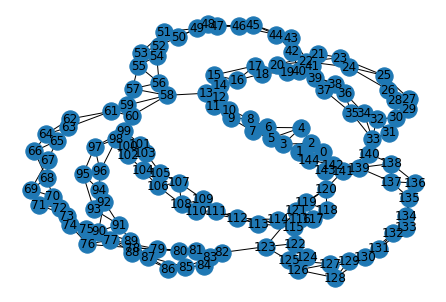

In [3]:
colony = Colony()
agents = [AcoAgent(seed=i, colony=colony, alpha=0.027, beta=3.0, c_d=3, c_t=1.4, eps=0.7, elitism_amount=0.5, evaporation_rate=0.5, evaporation_method="default_aco") for i in range(2)]
test1 = TestProblem(seed=42).hard_1(agents=agents)
test1.draw_adjacency()

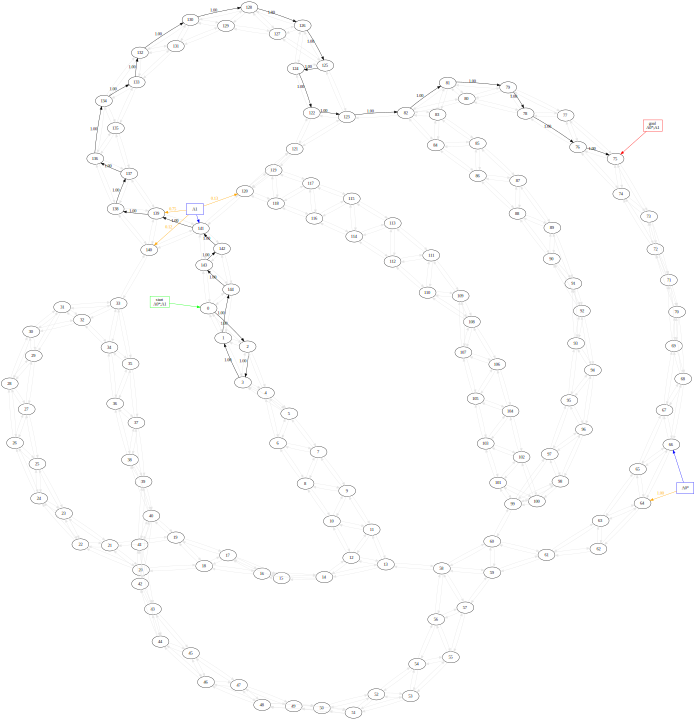

In [6]:
test1.step()
dot = test1.dot_graph(pheromones=colony.pheromones)
dot.attr(size="10,10")
display(dot)

In [5]:
for _ in range(100):
    test1.step()

In [ ]:

@ipp.require("pandas as pd", "numpy as np", GraphWorld, TestProblem, AcoAgent, Colony)
def run_testprolem_aco(seed=0, num_agents=1,**kwargs):
    c = Colony()
    agents = [AcoAgent(seed=seed+offset, colony=c, **kwargs) for offset in range(num_agents)]
    problem = TestProblem(seed=seed).hard_1(agents=agents)
    data = []
    for _ in range(10):
        for _ in range(50):
            problem.step()
        data.append(problem.get_data())
    return pd.concat(data)


In [ ]:
parameters = [
    Parameter(name="elitism_amount", default=0.05, space=np.logspace(-1, 1, num=5)),
    Parameter(name="alpha", default=1.0, space=np.logspace(-1, 1, num=5)),
    Parameter(name="beta", default=0.05, space=np.logspace(-1, 1, num=5)),
    Parameter(name="c_d", default=0.05, space=np.logspace(-1, 1, num=5)),
    Parameter(name="c_t", default=0.0),#, space=np.logspace(-1, 1, num=5)),
    Parameter(name="eps", default=0.003, space=np.logspace(-1, 1, num=5)),
    Parameter(name="num_agents", default=10)#, values=[1, 2, 5, 10, 20]),
             ]
experiment = Experiment(seed=1, function=run_testprolem_aco, parameters=parameters, runs=5)

In [ ]:
experiment.tasks = []
experiment.function = run_testprolem_aco
experiment.generate_tasks()

In [ ]:
df = experiment.run_map()

In [ ]:
df = experiment.results

In [ ]:
df = df.replace(np.inf, np.nan)
#df = df.set_index(["task_id"])
df['ratio'] = df["arrived"] / (df["stuck"] + df["arrived"])
df.head(20)

In [ ]:
sns.boxenplot(data=df, x="world_step_count", y="max_best_distance")
plt.show()

In [ ]:
experiment.save_results(filename="current.pkl")

In [ ]:
def explore_parameter(data=None, parameters=None, name="Name"):
    df = data
    for parameter in parameters:
        if parameter.name != name and parameter.name in df.keys():
            df = df.loc[df[parameter.name] == parameter.default]
    return df

def plot_parameter(data=None, parameters=None, name="Name", y="collisions", x="world_step_count", **kwargs):
    df_eps_f = explore_parameter(data=data, parameters=parameters, name=name)
    sns.catplot(data=df_eps_f, x=x, y=y, col=name, sharex=True, sharey=True, **kwargs)#, kind="box")
    

In [ ]:
for p in parameters:
    plot_parameter(data=df, parameters=parameters, name=p.name, y="median_best_distance", kind="box", legend=None)

In [ ]:
len(df["seed"].unique())

In [ ]:
world = TestProblem(seed=43).hard_2()
colony1 = Colony()
colony2 = Colony()
colony3 = Colony()
agents = [AcoAgent(colony=colony1, start=world.agents[0].start, goal=world.agents[0].goal, seed=seed) for seed in range(2)]
#agents += [AcoAgent(colony=colony2, start=10, goal=20, seed=seed) for seed in range(2)]
#agents += [AcoAgent(colony=colony3, start=20, goal=30, seed=seed) for seed in range(2)]
world.update_agents(agents)
for _ in range(1000):
    world.step(c_t = 0.1, c_d = 0.1, eps=0.01)
#print(f"{colony.pheromones}")
print(world.get_data())
dot = world.dot_graph(colony1.pheromones)
dot.attr(size="10,10")
display(dot)

In [ ]:
world.step()
dot = world.dot_graph(colony1.pheromones)
dot.attr(size="10,10")
display(dot)

In [ ]:
world = TestProblem(seed=43).hard_2()
colony1 = Colony()
colony2 = Colony()
colony3 = Colony()
agents = [AcoAgent(colony=colony1, start=world.agents[0].start, goal=world.agents[0].goal, seed=seed) for seed in range(2)]
agents += [AcoAgent(colony=colony2, start=10, goal=20, seed=seed) for seed in range(2)]
agents += [AcoAgent(colony=colony3, start=20, goal=30, seed=seed) for seed in range(2)]
world.update_agents(agents)
for _ in range(1000):
    world.step(c_t = 0.1, c_d = 0.1)
#print(f"{colony.pheromones}")
print(world.get_data())
dot = world.dot_graph(colony1.pheromones)
dot.attr(size="10,10")
display(dot)

In [3]:
remote_parameters = [
    Parameter(name="elitism_amount", default=0.05, space=np.logspace(-2, 2, num=7), optimize=True, low=0, high=1),
    Parameter(name="alpha", default=1.0, space=np.logspace(-1, 1, num=7), optimize=True, low=0, high=10),
    Parameter(name="beta", default=0.05, space=np.logspace(-1, 1, num=7), optimize=True, low=0, high=10),
    Parameter(name="c_d", default=0.05, space=np.logspace(-1, 1, num=7), optimize=True, low=0, high=3),
    Parameter(name="c_t", default=0.0, values = np.logspace(-2, 2, num=7)*0.01, optimize=True, low=0, high=3),
    Parameter(name="eps", default=0.003, space=np.logspace(-1.5, 1.5, num=7), optimize=True, low=0, high=3),
    Parameter(name="num_agents", default=10, values=[1, 2, 5, 10, 20]),
    Parameter(name="log_steps", default=100),
    Parameter(name="between_log_steps", default=10)
]
e = Experiment(with_cluster=False, parameters=remote_parameters)
e.save_parameters("test.json")

In [6]:
remote_parameters = [
    Parameter(name="elitism_amount", default=0.05, space=np.logspace(-2, 2, num=7), optimize=True, low=0, high=1),
    Parameter(name="alpha", default=1.0, space=np.logspace(-1, 1, num=7), optimize=True, low=0, high=10),
    Parameter(name="beta", default=0.05, space=np.logspace(-1, 1, num=7), optimize=True, low=0, high=10),
    Parameter(name="c_d", default=0.05, space=np.logspace(-1, 1, num=7), optimize=True, low=0, high=3),
    Parameter(name="c_t", default=0.0, values = np.logspace(-2, 2, num=7)*0.01, optimize=True, low=0, high=3),
    Parameter(name="eps", default=0.003, space=np.logspace(-1.5, 1.5, num=7), optimize=True, low=0, high=3),
    Parameter(name="num_agents", default=10, values=[1, 2, 5, 10, 20]),
    Parameter(name="evaopration_method", default="default_aco"),
    Parameter(name="evaporation_rate", default=0.99, low=0.5, high=1, optimize=True),
    Parameter(name="log_steps", default=100),
    Parameter(name="between_log_steps", default=10)
]
e = Experiment(with_cluster=False, parameters=remote_parameters)
e.save_parameters("data/default_evaporation.json")

In [ ]:
remote = Experiment(with_cluster=False)
remote.load_parameters("test.json")
params = remote.parameters
df = remote.load_results("test.pkl")
df = df.replace(np.inf, np.nan)
df['iteration'] = 100 * np.ceil(df['world_step_count'] / 100)
df['ratio'] = df["arrived"] / (df["stuck"] + df["arrived"])
df.loc[df["world_step_count"]==50].head(50)

In [ ]:
df["iteration"].unique()

In [ ]:
for p in params:
    plot_parameter(data=df, parameters=params, name=p.name,x="iteration", y="max_best_distance", kind="box", legend=None)